In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.3-py3-none-any.whl size=190250 sha256=081bbd1920ec6bb5d6228931d30651c1b27359dbe6692b373d6a7234be561d8e
  Stored in directory: /root/.cache/pip/wheels/05/f8/db/124d43bec122d6ec0ab3713fadfe25ebed8af52ec561682b4e
Successfully built pyod


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, GRU, Flatten, Dense
from tensorflow.keras.utils import to_categorical
# Import data
from pyod.models import hbos
from pyod.utils.data import evaluate_print
import pickle

In [ ]:
# EEG Signal Processing
class EEGDataset:
    def __init__(self, train_csv, seconds=0.3, fs=128, data_portion=1, normalize=True, isolated_channels=False):
        assert 0 < data_portion <= 1, 'data_portion should be > 0 and <= 1'
        self.isolated_channels = isolated_channels
        self.normalize = normalize
        self.train_csv = train_csv
        self.seconds = seconds
        self.fs = fs
        self.data_portion = data_portion

    def get_data(self):
        df = pd.read_csv(self.train_csv)
        array_size = int(self.seconds * self.fs)

        if self.normalize:
            df = (df - df.mean()) / df.std()

        if self.isolated_channels:
            channels = []
            for channel in df.columns[:32]:
                isolated_channel = []
                for i in range(int(len(df) / array_size)):
                    isolated_channel.append(df[channel][i*array_size:(i+1)*array_size].to_numpy())
                channels.append(np.array(isolated_channel))
            return np.array(channels)

        dataset = []
        for channel in df.columns[:32]:
            for i in range(int(len(df) / array_size)):
                dataset.append(df[channel][i*array_size:(i+1)*array_size].to_numpy())

        return np.array(dataset)

In [ ]:
# Load EEG Data
train_csv = "/content/drive/MyDrive/BIO/features_raw.csv"
eeg_dataset = EEGDataset(train_csv, seconds=0.3, fs=128, data_portion=1, normalize=True)
train_dataset = eeg_dataset.get_data()

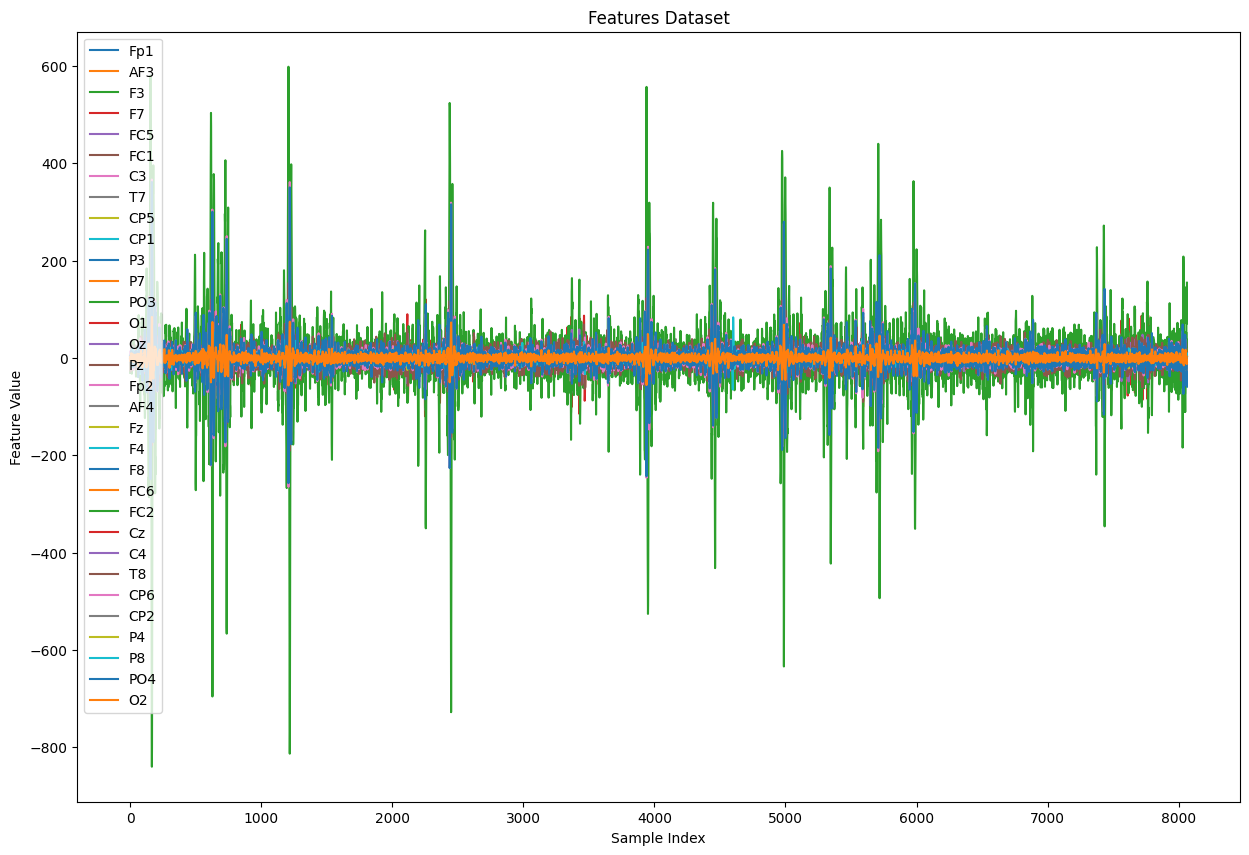

In [ ]:
# Drop the column named "Unnamed: 32"
# Load the features dataset
df = pd.read_csv('/content/drive/MyDrive/BIO/features_raw.csv')
df1 = df.drop(" ", axis=1, errors='ignore')

# Plot each feature individually
plt.figure(figsize=(15, 10))
for column in df.columns:
    plt.plot(df1[column], label=column)
plt.xlabel('Sample Index')
plt.ylabel('Feature Value')
plt.title('Features Dataset')
plt.legend()
plt.show()

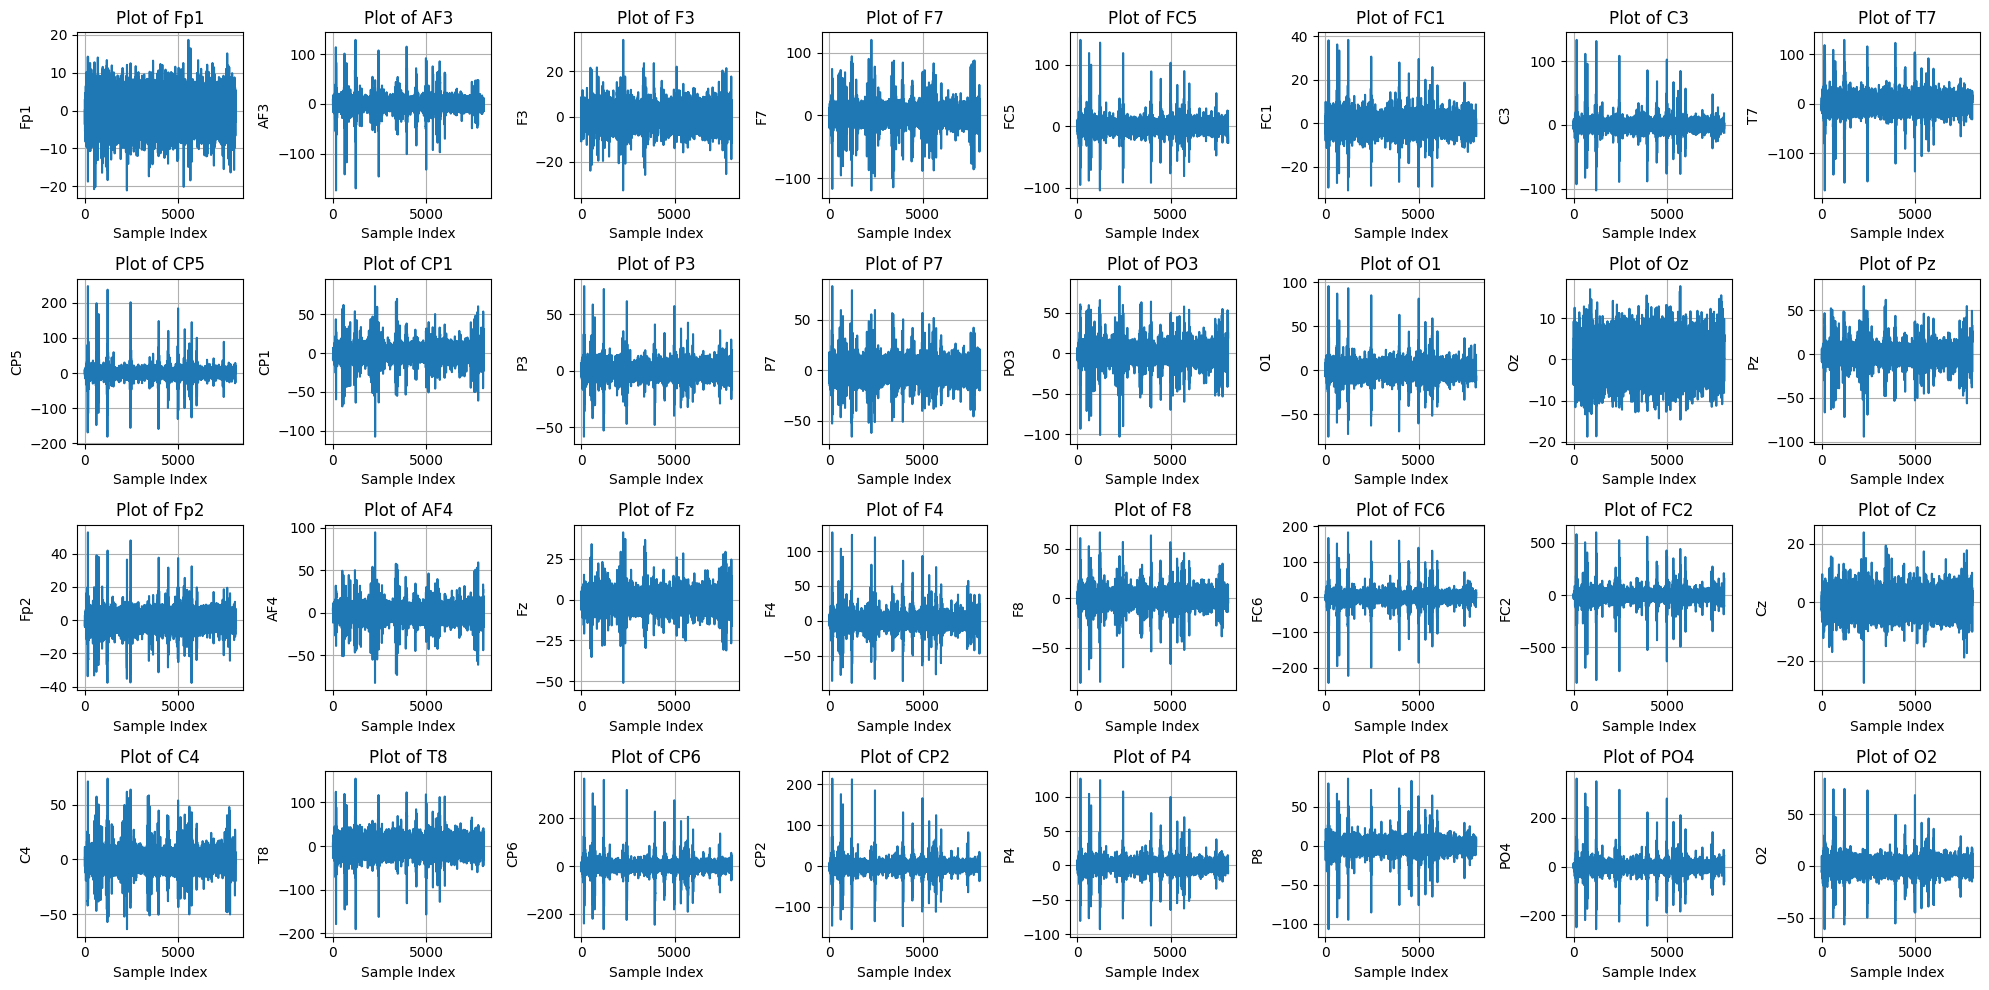

In [ ]:
# Load the features dataset
df2 = pd.read_csv('/content/drive/MyDrive/BIO/features_raw.csv')

# Exclude the column named 'Unnamed: 32'
df3 = df2.drop(columns=[''], errors='ignore')

# Calculate the number of rows and columns for subplots
num_columns = 8
num_rows = (len(df.columns) + num_columns - 1) // num_columns

# Plot each feature separately in subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 10))
for i, column in enumerate(df.columns):
    ax = axes[i // num_columns, i % num_columns]
    ax.plot(df3[column])
    ax.set_xlabel('Sample Index')
    ax.set_ylabel(column)
    ax.set_title(f'Plot of {column}')
    ax.grid(True)  # Add gridlines
plt.tight_layout()  # Adjust spacing
plt.show()

In [ ]:
# Emotion Classification
data = pd.read_csv("/content/drive/MyDrive/BIO/emotions.csv")

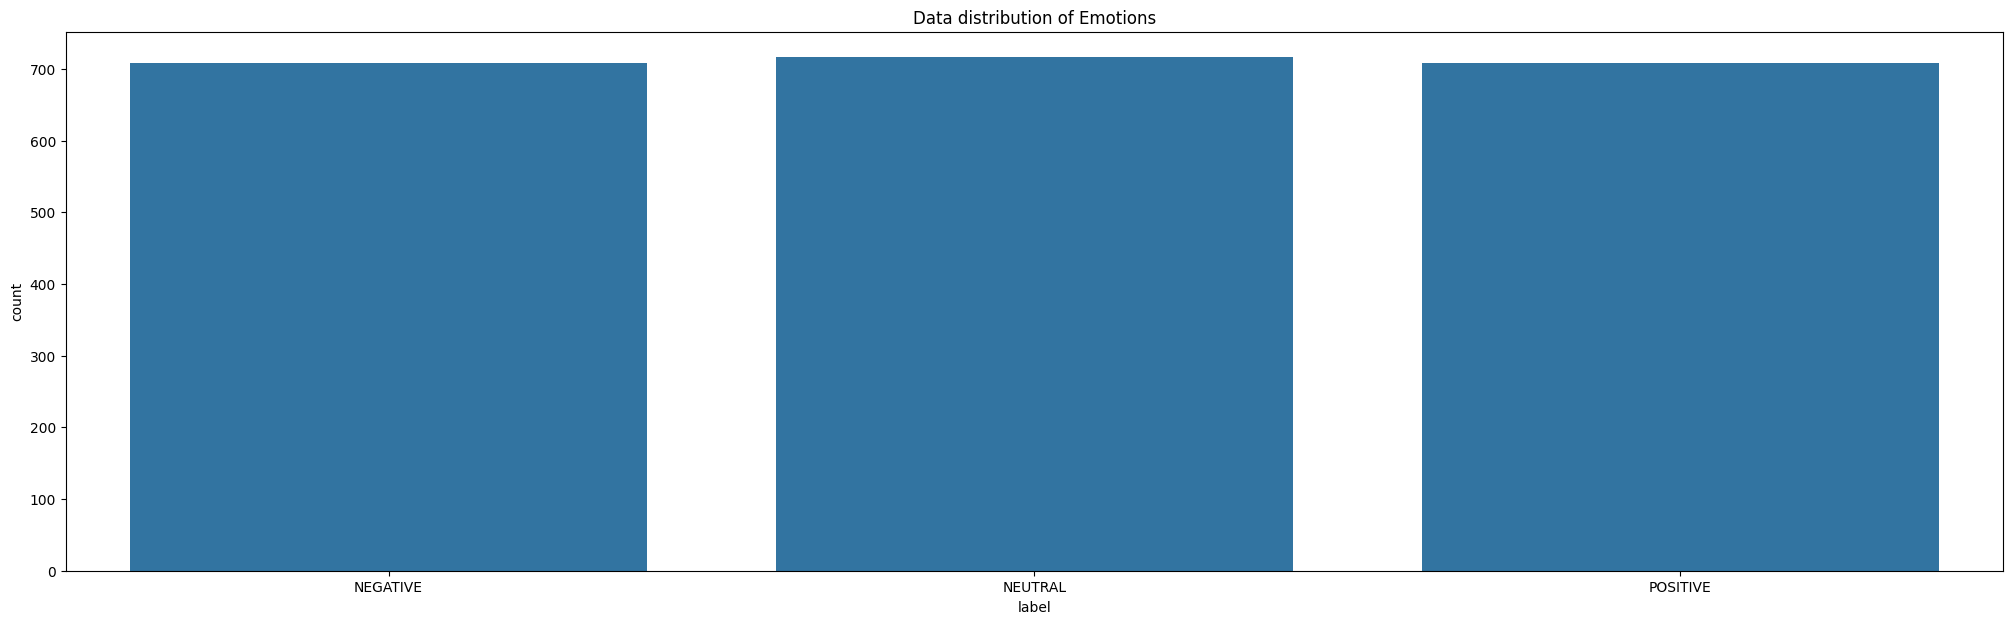

In [ ]:
# Plot data distribution
plt.figure(figsize=(25,7))
plt.title("Data distribution of Emotions")
sns.countplot(x='label', data=data)
plt.show()

In [ ]:
# Plot sample data
pos = data.loc[data["label"]=="POSITIVE"]
sample_pos = pos.loc[2, 'fft_0_b':'fft_749_b']
neg = data.loc[data["label"]=="NEGATIVE"]
sample_neg = neg.loc[0, 'fft_0_b':'fft_749_b']
neu = data.loc[data["label"]=="NEUTRAL"]
sample_neu = neu.loc[1, 'fft_0_b':'fft_749_b']

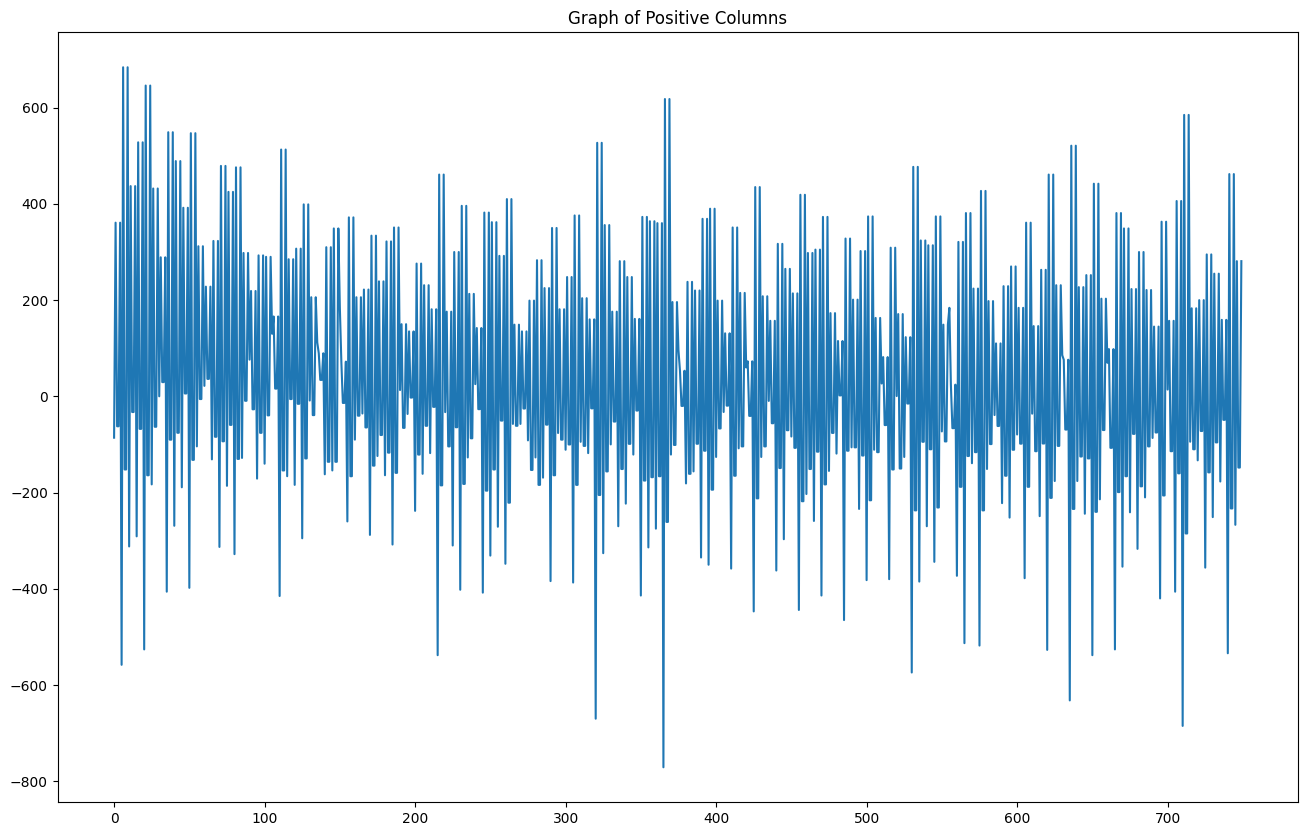

In [ ]:
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_pos)), sample_pos)
plt.title("Graph of Positive Columns")
plt.show()

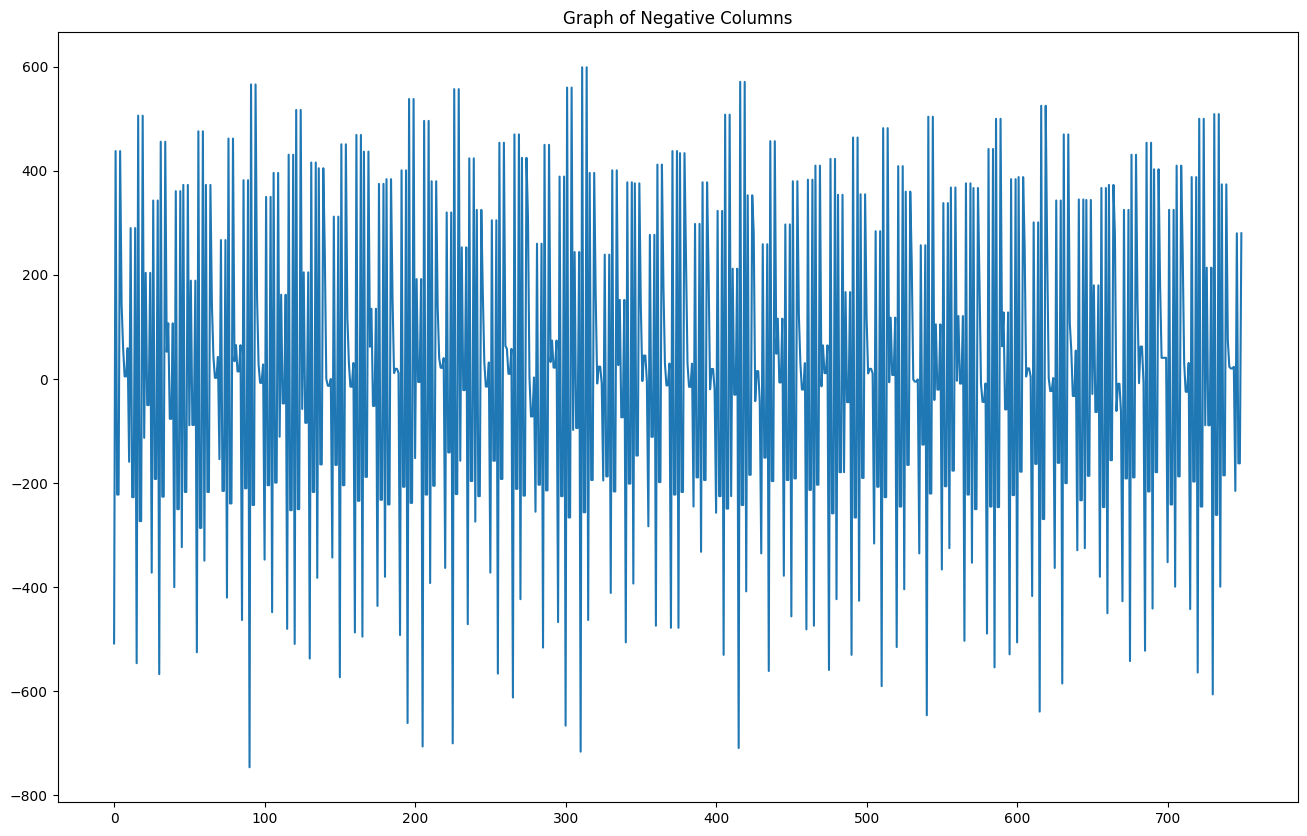

In [ ]:
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_neg)), sample_neg)
plt.title("Graph of Negative Columns")
plt.show()

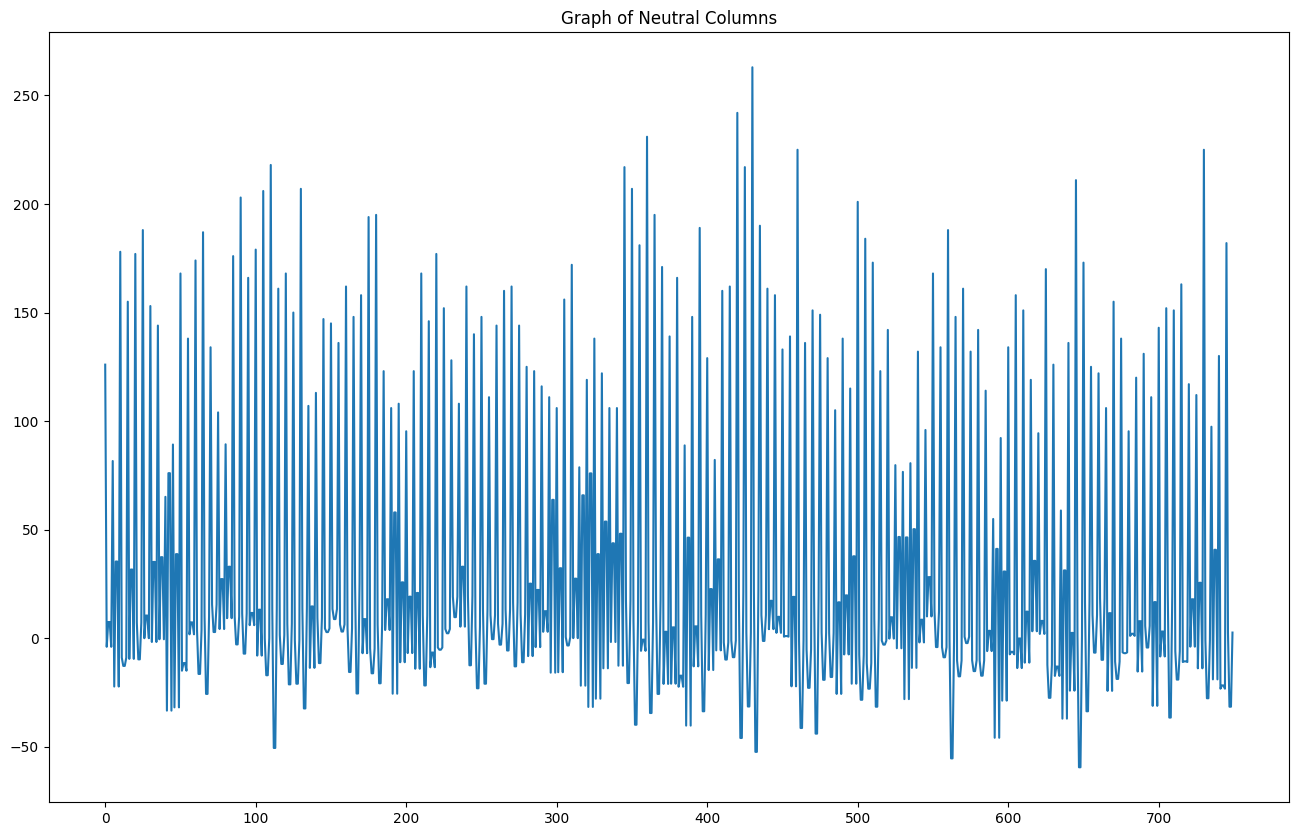

In [ ]:
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_neu)), sample_neu)
plt.title("Graph of Neutral Columns")
plt.show()

In [ ]:
# Data Transformation
def transform_data(data):
    encoder = LabelEncoder()
    data['label'] = encoder.fit_transform(data['label'])
    x = data.drop("label", axis=1)
    y = data['label']
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    y_encoded = to_categorical(y)
    return x_scaled, y_encoded

# Split data
X, Y = transform_data(data)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=4)

In [ ]:
# Define GRU-CNN model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),
    GRU(64, return_sequences=True),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Model Summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2546, 32)          128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1273, 32)          0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 1273, 32)          128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1273, 32)          0         
                                                                 
 gru (GRU)                   (None, 1273, 64)          18816     
                                                                 
 flatten (Flatten)           (None, 81472)             0

In [ ]:
# Train the model
history = model.fit(np.expand_dims(x_train, axis=2), y_train, epochs=20, validation_split=0.2, batch_size=32)

Epoch 1/15
43/43 [==============================] - 11s 68ms/step - loss: 2.1032 - accuracy: 0.8424 - val_loss: 0.2221 - val_accuracy: 0.9296
Epoch 2/15
43/43 [==============================] - 2s 40ms/step - loss: 0.2626 - accuracy: 0.9457 - val_loss: 0.2131 - val_accuracy: 0.9238
Epoch 3/15
43/43 [==============================] - 2s 41ms/step - loss: 0.1807 - accuracy: 0.9538 - val_loss: 0.1655 - val_accuracy: 0.9413
Epoch 4/15
43/43 [==============================] - 2s 40ms/step - loss: 0.0563 - accuracy: 0.9787 - val_loss: 0.0954 - val_accuracy: 0.9765
Epoch 5/15
43/43 [==============================] - 2s 41ms/step - loss: 0.0730 - accuracy: 0.9751 - val_loss: 0.0771 - val_accuracy: 0.9795
Epoch 6/15
43/43 [==============================] - 2s 44ms/step - loss: 0.0694 - accuracy: 0.9743 - val_loss: 0.0829 - val_accuracy: 0.9795
Epoch 7/15
43/43 [==============================] - 2s 50ms/step - loss: 0.0396 - accuracy: 0.9853 - val_loss: 0.0932 - val_accuracy: 0.9677
Epoch 8/15
4

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(np.expand_dims(x_test, axis=2), y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

14/14 [==============================] - 0s 31ms/step - loss: 0.1493 - accuracy: 0.9555
Test Loss: 0.14925000071525574, Test Accuracy: 0.955503523349762


In [ ]:
# Predictions
y_pred = model.predict(np.expand_dims(x_test, axis=2))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

14/14 [==============================] - 1s 15ms/step


In [ ]:
# Classification report
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       132
           1       0.94      0.99      0.97       153
           2       0.96      0.90      0.93       142

    accuracy                           0.96       427
   macro avg       0.96      0.95      0.96       427
weighted avg       0.96      0.96      0.96       427



<function matplotlib.pyplot.show(close=None, block=None)>

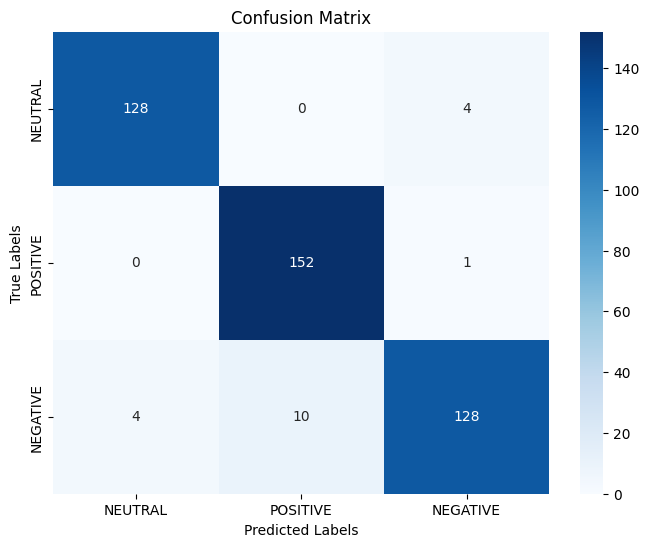

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NEUTRAL', 'POSITIVE', 'NEGATIVE'], yticklabels=['NEUTRAL', 'POSITIVE', 'NEGATIVE'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show

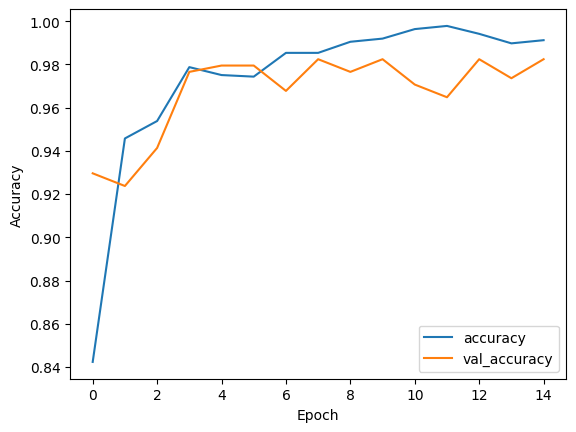

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()